<a id='sec0'></a>

# Optimizing n-class word extraction1 : relative difference

The extracted words here will be combined with others extracted in different ways

<a href='#sec1'><b>1. Import and pre-process data</b></a>

<a href='#sec2'><b>2. Frequency Optimization</b></a>
   
<a href='#sec3'><b>3. PCA & LDA</b></a>

In [146]:
import csv
import json
import random
import re
import numpy as np
import pandas as pd
import scipy.stats as scs
import matplotlib.pyplot as plt
import importlib as imp
import feature_engineering.frequency_selection as fefs
import myplot.decomposition as mpd

from xgboost import plot_importance
from pprint import pprint
from matplotlib  import cm
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

%matplotlib inline

<a id='sec1'></a>
# 1. Import and pre-process data
(<a href='#sec0'>Back to top</a>)

In [2]:
class_train = pd.read_csv('./data/training_variants')
text_train = pd.read_csv("./data/training_text", sep=r"\|\|", engine='python',
                         header=None, skiprows=1, names=["ID","Text"])
train = class_train.merge(text_train, on='ID')

# create class label container
class_labels = []
for i in range(9):
    class_labels.append('class' + str(i+1))

In [3]:
with open('./data/classified_docs.json') as f1:
    classified_docs = json.load(f1)

with open('./data/classified_tokenized_docs.json') as f2:
    classified_tokenized_docs = json.load(f2)

with open('./data/classified_texts.json') as f3:
    classified_texts = json.load(f3)

with open('./data/classified_tokenized_texts.json') as f4:
    classified_tokenized_texts = json.load(f4)

with open('./data/average_per_document_appearances.json') as f5:
    ave_perdoc_apps = json.load(f5)
    
with open('./data/fraction_of_documents_with_appearance.json') as f6:
    app_freqs = json.load(f6)

with open("./data/unclassified_tokenized_docs.csv", "r") as f:
    reader = csv.reader(f)
    unclassified_tokenized_docs = list(reader)

perdoc_apps = pd.DataFrame(ave_perdoc_apps).fillna(value=0)

In [4]:
%%time
fracdocs = pd.DataFrame(app_freqs).fillna(value=0)
n = 3000

top_words = []
for i in range(9):
    tops = fracdocs[class_labels[i]].sort_values(ascending=False).head(n)
    top_words.append(list(tops.index))

overlap1 = set(top_words[0])
for lis in top_words[1:]:
    overlap1.intersection_update(lis)
print('# intersecting words among top%d appearing words in each class: ', len(overlap1))
    
remove_list = []
for i in range(9):
    remove_words = [word for word in overlap1 \
                    if word in fracdocs[class_labels[i]] \
                    if fracdocs[class_labels[i]][word] > 0.5]
    remove_list.append(list(remove_words))

overlap2 = set(remove_list[0])
for lis in remove_list[1:]:
    overlap2.intersection_update(lis)
print('# intersecting words with >50% appearance: ', len(overlap2))

fracdocs_update1 = fracdocs.copy()
fracdocs_update1 = fracdocs_update1.drop(overlap2)
print('Table shape before removal: ', fracdocs.shape)
print('Table shape after removal:  ', fracdocs_update1.shape)

# intersecting words among top%d appearing words in each class:  1391
# intersecting words with >50% appearance:  287
Table shape before removal:  (125448, 9)
Table shape after removal:   (125161, 9)
CPU times: user 336 ms, sys: 8.97 ms, total: 345 ms
Wall time: 347 ms


<a id='sec2'></a>
# 2. Frequency Optimization
- Play with the cutoff frequency parameters
- Use relative difference and fraction_of_docs

(<a href='#sec0'>Back to top</a>)

In [6]:
%%time
# Basic setup & Parameters
y = np.array(class_train.Class).astype(int).ravel()
rfc = RandomForestClassifier(n_estimators=200, max_depth=12,
                             n_jobs=8, random_state=33)

min_diffs = [1.5, 1.45, 1.4, 1.35, 1.3]
min_freqs = [0.45, 0.4, 0.35, 0.3, 0.25, 0.2]
min_excl_freqs = [0.2, 0.175, 0.15, 0.125, 0.1]
num_iterations = len(min_diffs) * len(min_freqs) * len(min_excl_freqs)

params = []
results = []
counter = 1
print('params=(min_diff, min_freq, min_excl_freq)')
for i, diff in enumerate(min_diffs):
    for j, freq in enumerate(min_freqs):
        for k, excl_freq in enumerate(min_excl_freqs):
            param = (diff, freq, excl_freq)
            rfc_result = fefs.RFC_NClassWordsPlus(
                        unclassified_tokenized_docs, fracdocs_update1, y, 
                        exclusive_class=8, n_class=8, 
                        doc_type='fraction_of_docs', extract_mode='relative', 
                        min_difference=diff, min_frequency=freq, min_excl_frequency=excl_freq,
                        vector_type='tfidf', test_size=0.15, random_state=345, verbose=False,
                        rfc=rfc)
            result = (param, rfc_result)
            results.append(result)
            print('%d/%d completed: params=(%.3f, %.3f, %.3f), #features=%d, accuracy=%.3f, log_loss=%.3f'\
                   % (counter, num_iterations, diff, freq, excl_freq, 
                      len(rfc_result['feature_ids']), rfc_result['accuracy'], rfc_result['log_loss']))
            counter += 1

params=(min_diff, min_freq, min_excl_freq)
1/150 completed: params=(1.500, 0.450, 0.200), #features=186, accuracy=0.609, log_loss=1.096
2/150 completed: params=(1.500, 0.450, 0.175), #features=186, accuracy=0.609, log_loss=1.096
3/150 completed: params=(1.500, 0.450, 0.150), #features=446, accuracy=0.613, log_loss=1.168
4/150 completed: params=(1.500, 0.450, 0.125), #features=496, accuracy=0.605, log_loss=1.115
5/150 completed: params=(1.500, 0.450, 0.100), #features=534, accuracy=0.627, log_loss=1.116
6/150 completed: params=(1.500, 0.400, 0.200), #features=294, accuracy=0.631, log_loss=1.143
7/150 completed: params=(1.500, 0.400, 0.175), #features=294, accuracy=0.631, log_loss=1.143
8/150 completed: params=(1.500, 0.400, 0.150), #features=554, accuracy=0.609, log_loss=1.100
9/150 completed: params=(1.500, 0.400, 0.125), #features=604, accuracy=0.619, log_loss=1.153
10/150 completed: params=(1.500, 0.400, 0.100), #features=642, accuracy=0.613, log_loss=1.113
11/150 completed: params=(

88/150 completed: params=(1.400, 0.200, 0.150), #features=1835, accuracy=0.637, log_loss=1.086
89/150 completed: params=(1.400, 0.200, 0.125), #features=1883, accuracy=0.621, log_loss=1.151
90/150 completed: params=(1.400, 0.200, 0.100), #features=1919, accuracy=0.631, log_loss=1.093
91/150 completed: params=(1.350, 0.450, 0.200), #features=324, accuracy=0.635, log_loss=1.042
92/150 completed: params=(1.350, 0.450, 0.175), #features=324, accuracy=0.635, log_loss=1.042
93/150 completed: params=(1.350, 0.450, 0.150), #features=584, accuracy=0.635, log_loss=1.062
94/150 completed: params=(1.350, 0.450, 0.125), #features=634, accuracy=0.625, log_loss=1.118
95/150 completed: params=(1.350, 0.450, 0.100), #features=672, accuracy=0.649, log_loss=1.068
96/150 completed: params=(1.350, 0.400, 0.200), #features=471, accuracy=0.649, log_loss=1.051
97/150 completed: params=(1.350, 0.400, 0.175), #features=471, accuracy=0.649, log_loss=1.051
98/150 completed: params=(1.350, 0.400, 0.150), #features

Examine the result by plotting dependence of scores on parameters

In [123]:
# Extract info from the text file containing the copy of the
# above output.
with open("./data/nwords_parameterization1_results.txt", "r") as f1:
    reader = csv.reader(f1)
    param_result1 = list(reader)

# remove first entry because it's a title
del param_result1[0]

rearranged_result = []
for i in range(len(param_result1)):
    new_result = {}
    new_result['min_diff'] = float(re.search(r"[0-9.]{5}", param_result1[i][0]).group())
    new_result['min_freq'] = float(re.search(r"[0-9.]{5}", param_result1[i][1]).group())
    new_result['min_excl_freq'] = float(re.search(r"[0-9.]{5}", param_result1[i][2]).group())
    new_result['num_features'] = int(re.search(r"[0-9.]{3}", param_result1[i][3]).group())
    new_result['accuracy'] = float(re.search(r"[0-9.]{5}", param_result1[i][4]).group())
    new_result['log_loss'] = float(re.search(r"[0-9.]{5}", param_result1[i][5]).group())
    rearranged_result.append(new_result)
param_table1 = pd.DataFrame(rearranged_result)

param_table1 = param_table1[['min_diff', 'min_freq', 'min_excl_freq', 'num_features',
                             'accuracy', 'log_loss']]
param_table1.to_csv("./data/nwords_parameterization1.csv", index=False)

In [124]:
param_table1.head()

,min_diff,min_freq,min_excl_freq,num_features,accuracy,log_loss
0,1.5,0.45,0.200,186,0.609,1.096
1,1.5,0.45,0.175,186,0.609,1.096
2,1.5,0.45,0.150,446,0.613,1.168
3,1.5,0.45,0.125,496,0.605,1.115
4,1.5,0.45,0.100,534,0.627,1.116


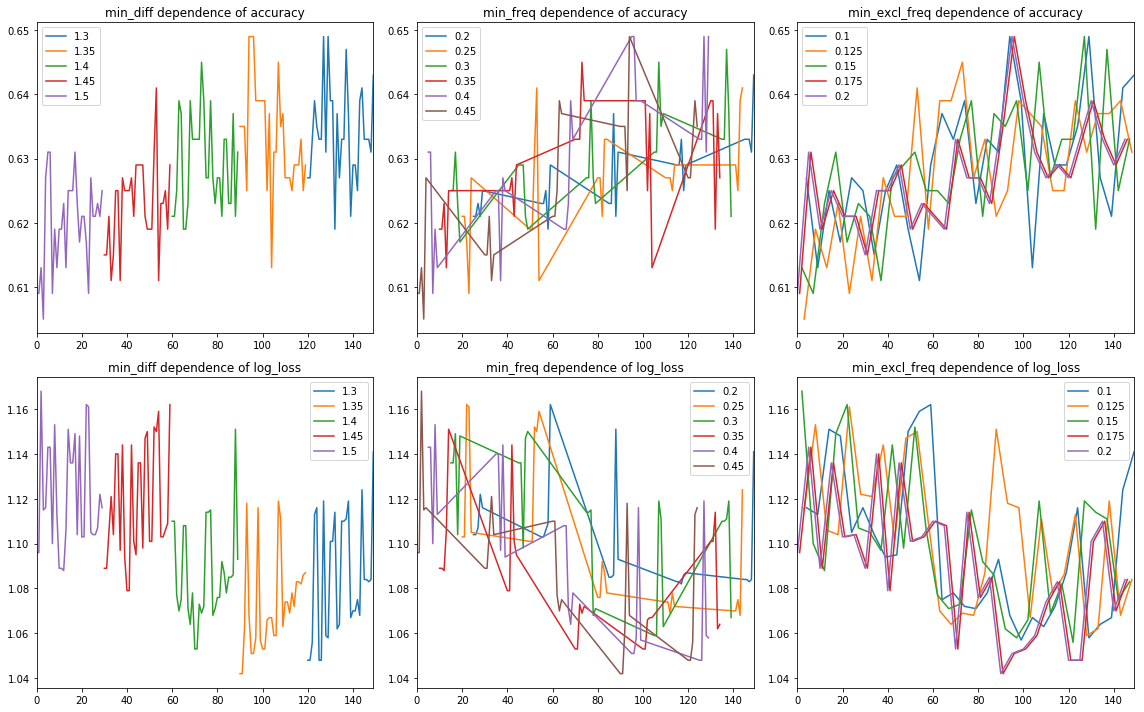

In [125]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(16, 10))
param_table1.groupby('min_diff')['accuracy'].plot(ax=ax1, title='min_diff dependence of accuracy', legend=True)
param_table1.groupby('min_diff')['log_loss'].plot(ax=ax4, title='min_diff dependence of log_loss', legend=True)
param_table1.groupby('min_freq')['accuracy'].plot(ax=ax2, title='min_freq dependence of accuracy', legend=True)
param_table1.groupby('min_freq')['log_loss'].plot(ax=ax5, title='min_freq dependence of log_loss', legend=True)
param_table1.groupby('min_excl_freq')['accuracy'].plot(ax=ax3, title='min_excl_freq dependence of accuracy', legend=True)
param_table1.groupby('min_excl_freq')['log_loss'].plot(ax=ax6, title='min_excl_freq dependence of log_loss', legend=True)
plt.tight_layout()

In [126]:
# Best result in terms of log loss
param_table1[param_table1['log_loss'] == np.min(param_table1['log_loss'])]

,min_diff,min_freq,min_excl_freq,num_features,accuracy,log_loss
90,1.35,0.45,0.200,324,0.635,1.042
91,1.35,0.45,0.175,324,0.635,1.042


In [128]:
y = np.array(class_train.Class).astype(int).ravel()
rfc = RandomForestClassifier(n_estimators=200, max_depth=12,
                             n_jobs=8, random_state=33)
validation_result = fefs.RFC_NClassWordsPlus(
                        unclassified_tokenized_docs, fracdocs_update1, y, 
                        exclusive_class=8, n_class=8, 
                        doc_type='fraction_of_docs', extract_mode='relative', 
                        min_difference=1.35, min_frequency=0.45, min_excl_frequency=0.175,
                        vector_type='tfidf', test_size=0.15, random_state=345, verbose=True,
                        rfc=rfc)

Extracting words...
324 words extracted...
Vectorizating texts...
6 of 3321 entries not covered by the extracted words
Training the classifier...
Making predictions...
===== Prediction Result =====
 - Accuracyl: 0.635
 - Log Loss: 1.042


In [134]:
select_words = list(validation_result['feature_ids'].keys())

validation_result2 = fefs.RFC_CustomWords(unclassified_tokenized_docs, fracdocs_update1, y, select_words,
                    vector_type='count', test_size=0.15, random_state=345, verbose=True,
                    rfc=rfc)

324 words selected...
Vectorizating texts...
6 of 3321 entries not covered by the extracted words
Training the classifier...
Making predictions...
===== Prediction Result =====
 - Accuracyl: 0.635
 - Log Loss: 1.042


<a id='sec3'></a>
# 3. PCA & LDA
<a href='#sec0'>Back to top</a>

In [137]:
selectX = validation_result2['feature_matrix']
print(selectX.shape)

(3321, 324)


<b>PCA</b>

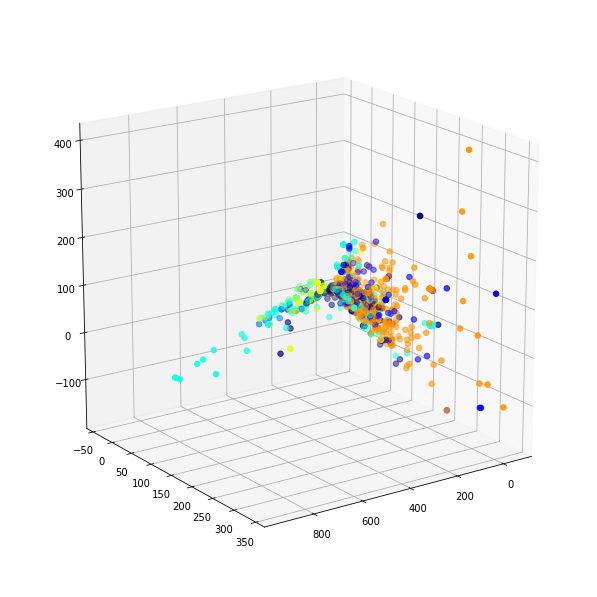

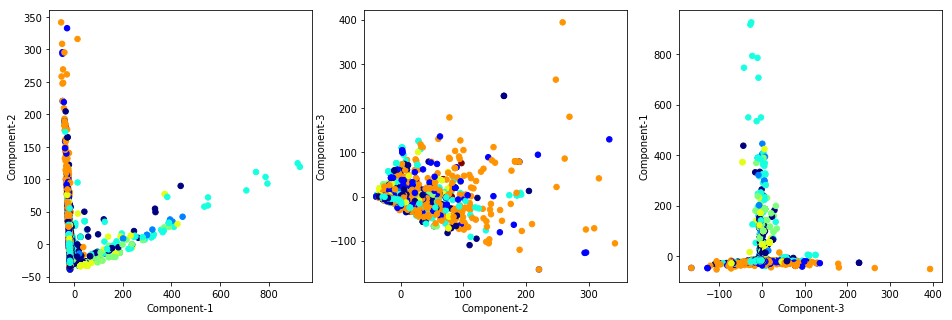

In [136]:
decomp_table = mpd.decomposition3D(selectX, class_train['Class'])
mpd.decomposition3DPlot(decomp_table, class_train['Class'])
mpd.decomposition2DPlot(decomp_table, class_train['Class'])

In [143]:
%%time
pca = PCA()
rfc = RandomForestClassifier(n_estimators=100, max_depth=50, n_jobs=7, random_state=33)

X_train, X_test, y_train, y_test = train_test_split(selectX, y, test_size=0.15, random_state=345)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train.shape, X_train_pca.shape)
print(X_test.shape, X_test_pca.shape)

rfc.fit(X_train_pca, y_train)

accuracy = accuracy_score(y_test, rfc.predict(X_test_pca))
lloss = log_loss(y_test, rfc.predict_proba(X_test_pca), labels=list(range(1, 10)))

print('Accuracy %.3f' % accuracy)
print('Log Loss %.3f' % lloss)

(2822, 324) (2822, 324)
(499, 324) (499, 324)
Accuracy 0.621
Log Loss 1.431
CPU times: user 3.72 s, sys: 15.8 ms, total: 3.74 s
Wall time: 1.04 s


<b>LDA</b>

/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


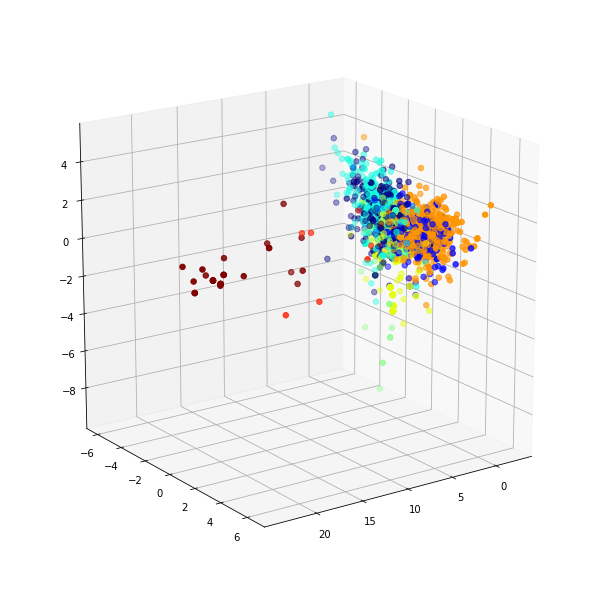

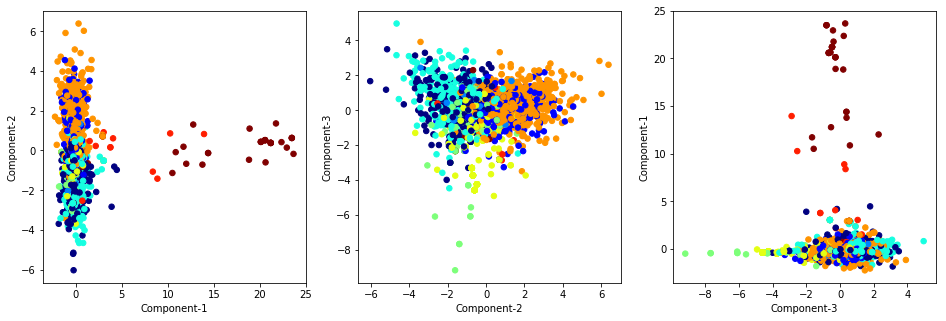

In [139]:
decomp_table = mpd.decomposition3D(selectX, class_train['Class'], 
                y=y, decomposer=LinearDiscriminantAnalysis(n_components=3))
mpd.decomposition3DPlot(decomp_table, class_train['Class'])
mpd.decomposition2DPlot(decomp_table, class_train['Class'])

In [144]:
%%time
lda = LinearDiscriminantAnalysis()
rfc = RandomForestClassifier(n_estimators=100, max_depth=50, n_jobs=7, random_state=33)

X_train, X_test, y_train, y_test = train_test_split(selectX, y, test_size=0.15, random_state=345)
lda.fit(X_train, y_train)
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)
print(X_train.shape, X_train_lda.shape)
print(X_test.shape, X_test_lda.shape)

rfc.fit(X_train_lda, y_train)

accuracy = accuracy_score(y_test, rfc.predict(X_test_lda))
lloss = log_loss(y_test, rfc.predict_proba(X_test_lda), labels=list(range(1, 10)))

print('Accuracy %.3f' % accuracy)
print('Log Loss %.3f' % lloss)

/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(2822, 324) (2822, 8)
(499, 324) (499, 8)
Accuracy 0.607
Log Loss 1.750
CPU times: user 804 ms, sys: 17.3 ms, total: 821 ms
Wall time: 605 ms


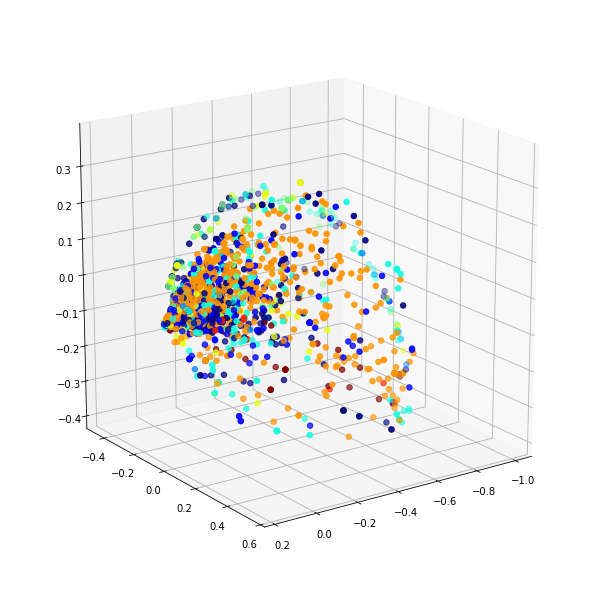

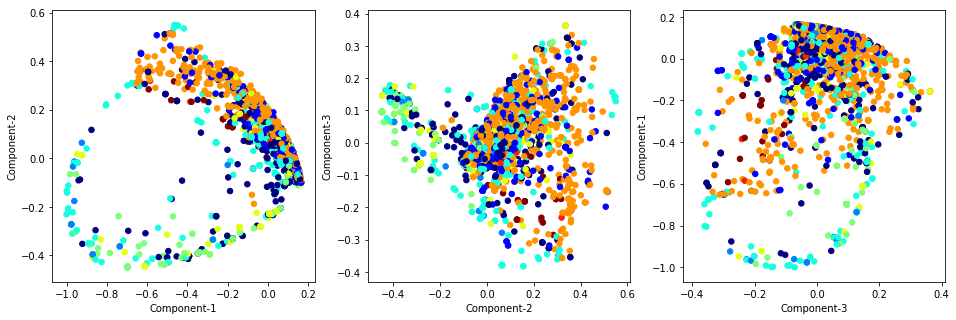

In [145]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(kernel="rbf", gamma=0.000015, n_components=3, n_jobs=8)
decomp_table = mpd.decomposition3D(selectX, class_train['Class'], 
                                y=y, decomposer=kpca)
mpd.decomposition3DPlot(decomp_table, class_train['Class'])
mpd.decomposition2DPlot(decomp_table, class_train['Class'])